<a href="https://colab.research.google.com/github/Rahafzsh/SpeechEmotionsRecognition/blob/main/Pre_Processing_SER_(With_Surprise_Class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing Audio files (With Surprise Class)**

#  Importing


In [1]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from time import sleep, time
from sklearn.metrics import roc_curve, auc

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Datasets paths


In [4]:
# Data
Ravdess = "/content/drive/MyDrive/SER (Dataset)/RAVDESS/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/SER (Dataset)/CREMA/"
Savee = "/content/drive/MyDrive/SER (Dataset)/SAVEE/"


## <center>1. Ravdess Dataset</center>

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        #The third part of the name represents the emotion in the dialogue
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(10)
Ravdess_df.Emotions.value_counts()

Emotions
neutral     288
happy       192
angry       192
sad         192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64

## <center>2. Crema Dataset</center>

In [6]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
Crema_df.Emotions.value_counts()

Emotions
happy      1271
sad        1271
disgust    1271
angry      1271
fear       1271
neutral    1087
Name: count, dtype: int64

##  <center> 3. Savee dataset <center>

In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
Savee_df.Emotions.value_counts()

Emotions
neutral     120
disgust      60
angry        60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64

# Data Integration <center>

In [8]:
data_path = pd.concat([Ravdess_df, Savee_df, Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()
data_path.Emotions.value_counts()

Emotions
happy       1523
angry       1523
sad         1523
disgust     1523
fear        1523
neutral     1495
surprise     252
Name: count, dtype: int64

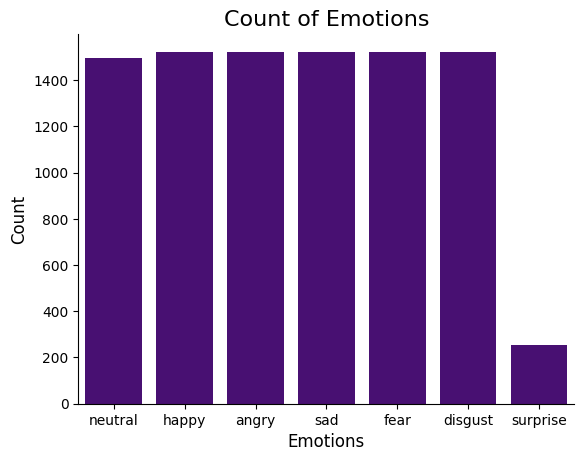

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = sns.color_palette(["#4B0082", "#8A2BE2", "#9932CC", "#BA55D3", "#DDA0DD", "#EE82EE"])
sns.set_palette(custom_palette)

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


Functions for:
* Waveplots
* Spectograms
* MFCC

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('The waveform for the sound in emotion {}'.format(e), size=10)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # Fourier.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {}'.format(e), size=10)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def create_mfcc(data,sr,e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12,3))
    plt.title('Mel-frequency cepstral coefficient for {}'.format(e), size=10)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

# Functions for extracting audio features:

In [11]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
#RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
#MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [12]:
# example feature vectors extracted from the audio data
fname = Savee + 'DC_f11.wav'
data, sampling_rate = librosa.load(fname, duration=2.5, offset=0.6)
print("ZCR: ", zcr(data).shape)
print("RMS :", rmse(data).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
RMS : (108,)
MFCC:  (2160,)


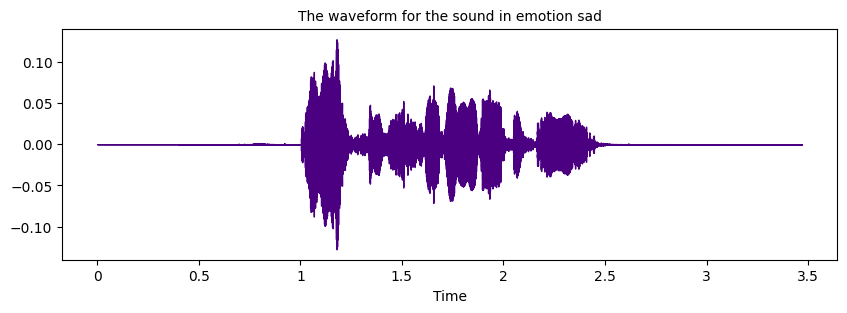

22050


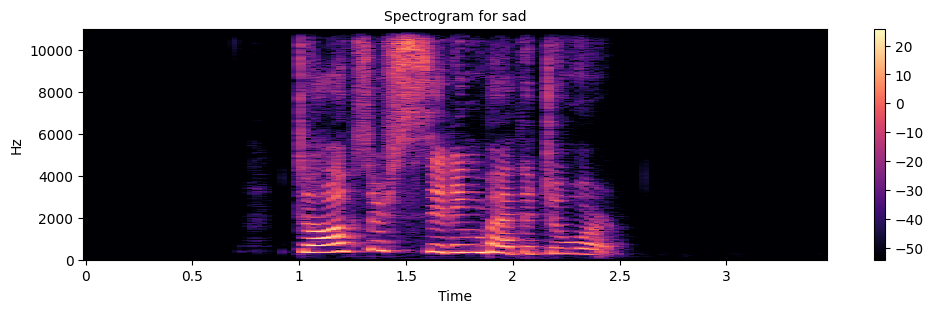

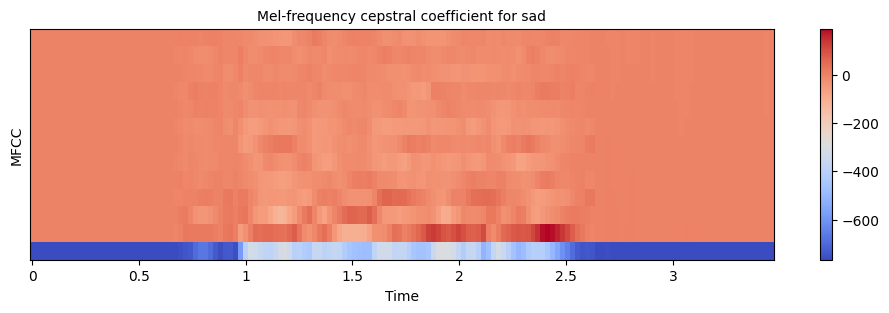

In [13]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data,sampling_rate,emotion)
Audio(path)

print(sampling_rate)

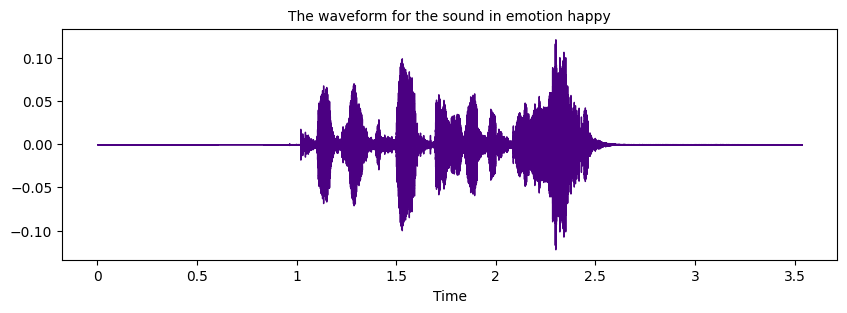

22050


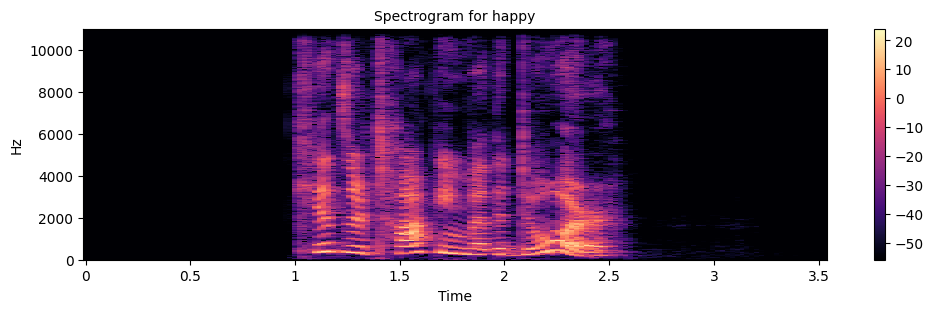

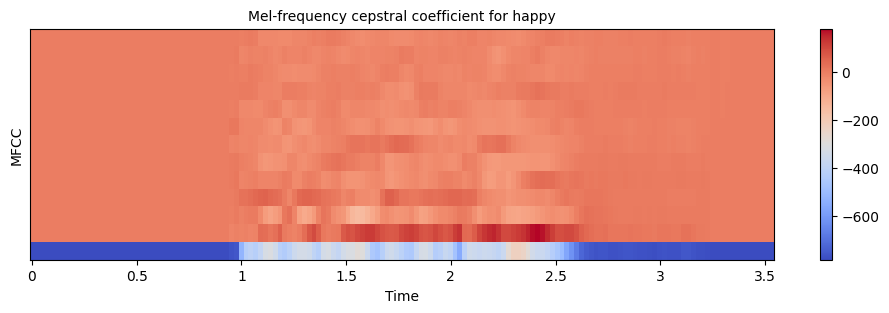

In [14]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data,sampling_rate,emotion)
Audio(path)
print(sampling_rate)

# Data Augmentation Functions for Audio Processing

In [15]:
# These functions are used to perform data augmentation on audio signals

def noise(data,noise_rate=0.015):
    noise_amp = noise_rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

path = np.array(data_path.Path)[2]
data, sample_rate = librosa.load(path)

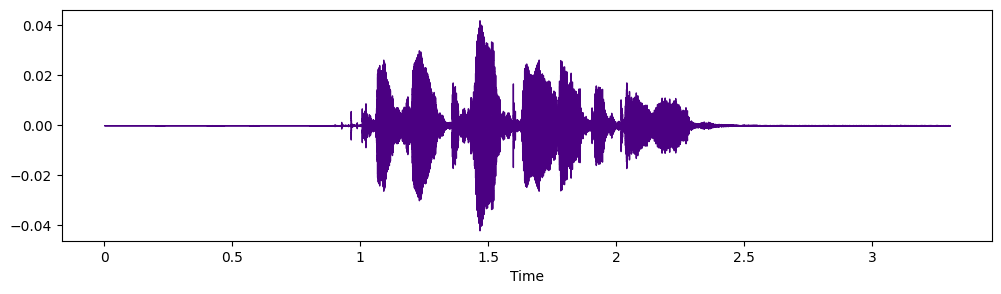

In [16]:
#Audio without augmentation
plt.figure(figsize=(12,3))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

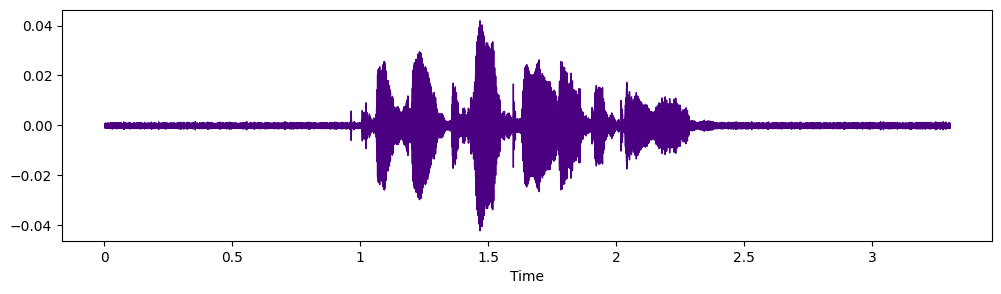

In [17]:
#Audio with noise added
x = noise(data)
plt.figure(figsize=(12,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### Shifting

22050

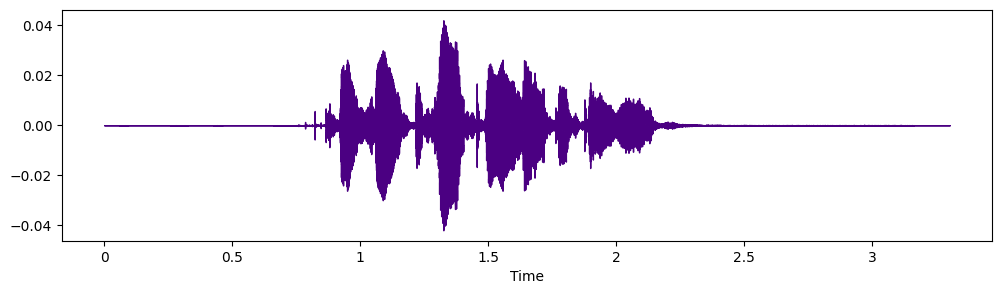

In [18]:
# Audio with shift added
x = shift(data)
plt.figure(figsize=(12,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)
sample_rate

In [19]:
hop_length = 512

In [20]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
#RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
#MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [21]:
# Extract features and stack them into a one-dimensional matrix
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

#Utalizing GPU for Feature Extraction and Model Training


In [22]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print('GPU is available!')
else:
    print('GPU is not available.')

GPU is available!


In [23]:
# Define a tensor (replace this with your actual tensor creation)
tensor = torch.randn(3, 3)

# Move tensors/models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensor to GPU
tensor = tensor.to(device)

In [24]:
def get_features(path):
    #duration, offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2))

    return result

### Features extraction by sequential processing:

In [25]:
X, Y = [], []
start_time = time()
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

sequential_execution_time = time() - start_time

print("Execution Time (Sequential processing): ", sequential_execution_time)

Execution Time (Sequential processing):  5652.1160225868225


### Features extraction by parallel processing:

In [26]:
from concurrent.futures import ThreadPoolExecutor

start_time = time()

# Appending emotion many times as we have made many augmentation techniques on each audio file.
def process_audio_file(path, emotion, X, Y):
  feature = get_features(path)
  for ele in feature:
      X.append(ele)
      Y.append(emotion)
  return (path, emotion)

if __name__ == "__main__":
    Q, R = [], []
    with ThreadPoolExecutor() as executor:
        f = []
        for path, emotion in zip(data_path.Path, data_path.Emotions):
            future = executor.submit(process_audio_file, path, emotion, Q, R)
            f.append(future)

        for future in f:
            path, emotion = future.result()


parallel_execution_time = time() - start_time

print("Execution Time (Parallel processing): ", parallel_execution_time)

Execution Time (Parallel processing):  471.33530139923096


In [27]:
len(X), len(Y), data_path.Path.shape

(18724, 18724, (9362,))

In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features(withSurpriseClass).csv', index=False)
Features.head(20)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.241699,0.367188,0.504395,0.478516,0.525879,0.518066,0.501465,0.469238,0.461426,0.477051,...,-7.295114,-4.029243,9.299549,12.841879,7.419748,4.341983,2.004731,2.757599,2.666527,neutral
1,0.225098,0.356934,0.481934,0.487793,0.511719,0.504395,0.500488,0.487793,0.490234,0.487305,...,2.988668,-4.095453,2.146642,3.440647,4.796884,5.649948,-0.667433,2.657712,0.087292,neutral
2,0.167969,0.167969,0.167969,0.004883,0.000000,0.000000,0.000000,0.008789,0.241211,0.373047,...,-12.609936,-2.088007,-4.638242,-8.565649,-1.704035,1.969478,-2.567831,-14.171959,6.574818,neutral
3,0.249023,0.371094,0.502930,0.497559,0.495605,0.509766,0.498535,0.514648,0.520508,0.500000,...,-7.230924,-2.890782,-0.010619,-1.840319,-2.578828,1.116183,-3.946343,-4.075680,-3.731382,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008301,0.138672,0.138672,...,-1.257085,-0.928518,-1.008308,-1.333871,-1.670438,-1.808489,-1.636770,-1.168537,-0.518752,neutral
5,0.244629,0.381348,0.513184,0.515625,0.527344,0.513672,0.506836,0.500488,0.489746,0.499023,...,-0.544646,0.065389,-2.757840,-3.536909,-0.627268,2.363821,1.307955,-1.022175,-2.455956,neutral
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.080078,0.241211,0.409668,0.611816,0.680176,...,0.155727,-0.443507,-1.186213,-1.758247,-1.894166,-1.604194,-1.208966,-1.126368,-1.564620,happy
7,0.244141,0.372070,0.502441,0.504883,0.504395,0.495605,0.476562,0.468750,0.474609,0.487305,...,2.853208,3.579232,-0.189534,-0.584508,5.356142,0.658111,1.616236,2.439328,-4.252220,happy
8,0.151855,0.227539,0.302734,0.300781,0.307617,0.291504,0.289551,0.284180,0.266113,0.256348,...,-0.284781,0.153858,9.381771,12.084583,9.921146,-0.537236,11.031258,10.110535,6.305238,neutral
9,0.231445,0.345215,0.457031,0.447266,0.448730,0.432129,0.435547,0.448730,0.439453,0.443359,...,-0.372668,-4.163587,7.201636,10.318539,11.167946,6.945987,4.940486,10.470125,5.844283,neutral
